In [25]:
import numpy as np
import seaborn as sns
import pandas as pd
import gzip
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression,LogisticRegressionCV
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
import nltk
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api
import gensim
import torch
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt  
from sklearn import datasets, metrics, model_selection, svm
from sklearn.metrics import roc_curve

In [3]:
DATA_DIR = '../data'
RAW_FILE_NAMES = ['reviews_Digital_Music_5.json.gz', 
                  'reviews_Musical_Instruments_5.json.gz',
                  'reviews_Toys_and_Games_5.json.gz']

## Load Raw Data

In [4]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path_dir, file_list):
    int_dfs = []
    for file in file_list:
        abs_path = os.path.join(path_dir, file)
        i = 0
        df = {}
        for d in parse(abs_path):
            df[i] = d
            i += 1
        int_dfs.append(pd.DataFrame.from_dict(df, orient='index'))
        
    return pd.concat(int_dfs, axis=0)

df_raw_data = getDF(DATA_DIR, RAW_FILE_NAMES)
df_raw_data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3EBHHCZO6V2A4,5555991584,"Amaranth ""music fan""","[3, 3]","It's hard to believe ""Memory of Trees"" came ou...",5.0,Enya's last great album,1158019200,"09 12, 2006"
1,AZPWAXJG9OJXV,5555991584,bethtexas,"[0, 0]","A clasically-styled and introverted album, Mem...",5.0,Enya at her most elegant,991526400,"06 3, 2001"
2,A38IRL0X2T4DPF,5555991584,bob turnley,"[2, 2]",I never thought Enya would reach the sublime h...,5.0,The best so far,1058140800,"07 14, 2003"
3,A22IK3I6U76GX0,5555991584,Calle,"[1, 1]",This is the third review of an irish album I w...,5.0,Ireland produces good music.,957312000,"05 3, 2000"
4,A1AISPOIIHTHXX,5555991584,"Cloud ""...""","[1, 1]","Enya, despite being a successful recording art...",4.0,4.5; music to dream to,1200528000,"01 17, 2008"


# Drop Useless Columns

In [5]:
df_raw_data = df_raw_data.reset_index().drop(columns=[
    'index', 'asin','reviewerName','reviewTime', 'unixReviewTime', 'reviewerID'])
df_raw_data['reviewText'] = df_raw_data['reviewText'].fillna('')
df_raw_data['summary'] = df_raw_data['summary'].fillna('')

df_raw_data.head()

,helpful,reviewText,overall,summary
0,"[3, 3]","It's hard to believe ""Memory of Trees"" came ou...",5.0,Enya's last great album
1,"[0, 0]","A clasically-styled and introverted album, Mem...",5.0,Enya at her most elegant
2,"[2, 2]",I never thought Enya would reach the sublime h...,5.0,The best so far
3,"[1, 1]",This is the third review of an irish album I w...,5.0,Ireland produces good music.
4,"[1, 1]","Enya, despite being a successful recording art...",4.0,4.5; music to dream to


# Calculate Proportion and Drop Helpfulness

In [6]:
df_raw_data['proportion'] = df_raw_data['helpful'].apply(lambda l: l[0]/l[1] if (isinstance(l, list) and l[1] != 0) else -1)
df_raw_data.drop(columns=['helpful'], inplace=True)
df_raw_data = df_raw_data[df_raw_data.proportion != -1].reset_index().drop(columns=['index'])
print(df_raw_data.shape)
df_raw_data.head()

(114771, 4)


,reviewText,overall,summary,proportion
0,"It's hard to believe ""Memory of Trees"" came ou...",5.0,Enya's last great album,1.000000
1,I never thought Enya would reach the sublime h...,5.0,The best so far,1.000000
2,This is the third review of an irish album I w...,5.0,Ireland produces good music.,1.000000
3,"Enya, despite being a successful recording art...",4.0,4.5; music to dream to,1.000000
4,Who knows why I initially considered this to b...,5.0,Dreamy unearthly magic continues with Eire's o...,0.953846


In [7]:
print(df_raw_data['proportion'].describe()['50%'])
df_raw_data['proportion'].describe()

threshold = df_raw_data['proportion'].describe()['50%']

0.9090909090909091


In [8]:
df_raw_data['helpful'] = df_raw_data['proportion'].apply(lambda d: 1 if d >= threshold else 0)

## Methods for Punctuation Features

In [9]:
def get_symbol_counts(texts, symbols, split):
    
    count_array = np.array([texts.str.count(symbol) for symbol in symbols]).T
    
    return pd.DataFrame(count_array, columns=['{}_{}_count'.format(symbol, split) for symbol in symbols])

## Methods for Actual Word Features

In [10]:
def remove_punctuation_and_numbers(s):
    s = re.sub(r'\d+', '', s)
    s = re.sub(r'[^a-zA-Z\s]+', '', s)
    s = s.strip()
    return s

def remove_space(s):
    return " ".join(s.split())

def get_tfidf_vector(texts, split):
    
    cleaned_texts = texts.apply(remove_space).apply(remove_punctuation_and_numbers)
    
    vectorizer = TfidfVectorizer(max_features=300)
    int_repr = vectorizer.fit_transform(cleaned_texts)
    return pd.DataFrame(int_repr.toarray(),
                        columns=["{}_{}_tfidf".format(feature_name, split) for feature_name in vectorizer.get_feature_names()])


def get_count_vector(texts, split):
    
    cleaned_texts = texts.apply(remove_space).apply(remove_punctuation_and_numbers)
    
    vectorizer = CountVectorizer(max_features=300)
    int_repr = vectorizer.fit_transform(cleaned_texts)
    return pd.DataFrame(int_repr.toarray(),
                        columns=["{}_{}_count".format(feature_name, split) for feature_name in vectorizer.get_feature_names()])



def get_pretrained_doc_embeddings(texts, split):
    def word_averaging(wv, words):
        all_words, mean = set(), []

        for word in words:
            if isinstance(word, np.ndarray):
                mean.append(word)
            elif word in wv.key_to_index:
                mean.append(wv.get_vector(word, norm=True) )
#                 mean.append(wv.syn0norm[wv.vocab[word].index])
                all_words.add(wv.key_to_index[word])
#                 all_words.add(wv.vocab[word].index)

        if not mean:
            print("cannot compute similarity with no input %s", words)
            # FIXME: remove these examples in pre-processing
            return np.zeros(wv.vector_size,)

        mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
        return mean

    def  word_averaging_list(wv, text_list):
        return np.vstack([word_averaging(wv, review) for review in text_list])
    
    def w2v_tokenize_text(text):
        tokens = []
        for sent in nltk.sent_tokenize(text, language='english'):
            for word in nltk.word_tokenize(sent, language='english'):
                if len(word) < 2:
                    continue
                tokens.append(word)
        return tokens
    
    tokenized_text = texts.apply(lambda sentence: w2v_tokenize_text(sentence))
    wv = api.load('word2vec-google-news-300')
    
    embeddings = word_averaging_list(wv,tokenized_text)
    return pd.DataFrame(embeddings,
                       columns=["{}_{}_word2vec_mean_emb".format(i, split) for i in range(1, embeddings.shape[1] + 1)])
    

get_pretrained_doc_embeddings(pd.Series(["this is a test. hello world!", "Another test"]), 'Foo').shape                     


(2, 300)

In [11]:
def generate_features(df, word_feature_type, symbols):
    
    assert word_feature_type in ['count', 'tfidf', 'word_embed']
    
    intermediate_dfs = []
    
    for split in ['reviewText', 'summary']:
        
        if word_feature_type == 'count':
            intermediate_dfs.append(get_count_vector(df[split], split))
            
        elif word_feature_type == 'tfidf':
            intermediate_dfs.append(get_tfidf_vector(df[split], split))
            
        else:
            intermediate_dfs.append(get_pretrained_doc_embeddings(df[split], split))
            
        
        intermediate_dfs.append(get_symbol_counts(df[split], symbols, split))
    
    # append readability features here
#     intermediate_dfs.append(generate_subject_stats(texts['subject']))
    
    return pd.concat(intermediate_dfs, axis=1)

In [16]:

final_df = df_raw_data[['overall', 'proportion']]
feature_df = generate_features(df_raw_data, 'count', ['\.', '\$', '!', '#',',', '%', '='])

final_df = pd.concat([final_df, feature_df], axis=1)
final_df.head()

,overall,proportion,about_reviewText_count,actually_reviewText_count,after_reviewText_count,again_reviewText_count,album_reviewText_count,albums_reviewText_count,all_reviewText_count,almost_reviewText_count,...,you_summary_count,young_summary_count,your_summary_count,\._summary_count,\$_summary_count,!_summary_count,#_summary_count,",_summary_count",%_summary_count,=_summary_count
0,5.0,1.000000,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5.0,1.000000,0,1,0,0,1,0,2,0,...,0,0,0,0,0,0,0,0,0,0
2,5.0,1.000000,3,0,0,0,3,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,4.0,1.000000,1,1,2,1,6,4,2,3,...,0,0,0,1,0,0,0,0,0,0
4,5.0,0.953846,0,1,0,0,2,3,2,0,...,0,0,0,0,0,1,0,0,0,0


In [22]:
# final_df['verified'] = final_df['verified'].replace({True: 1, False: 0})
# final_df['vote'] = final_df['vote'].apply(lambda s: s.replace(',', '')).astype('int64')

In [24]:
X_train, X_test, y_train, y_test = train_test_split(final_df.drop(columns=['proportion']), 
                                                    final_df['proportion'], train_size=0.9)
X_train.head()

,overall,1_reviewText_word2vec_mean_emb,2_reviewText_word2vec_mean_emb,3_reviewText_word2vec_mean_emb,4_reviewText_word2vec_mean_emb,5_reviewText_word2vec_mean_emb,6_reviewText_word2vec_mean_emb,7_reviewText_word2vec_mean_emb,8_reviewText_word2vec_mean_emb,9_reviewText_word2vec_mean_emb,...,298_summary_word2vec_mean_emb,299_summary_word2vec_mean_emb,300_summary_word2vec_mean_emb,\._summary_count,\$_summary_count,!_summary_count,#_summary_count,",_summary_count",%_summary_count,=_summary_count
3151,5.0,0.070174,0.053958,0.000758,0.094252,-0.028482,-0.063246,-0.005752,-0.135614,0.091717,...,0.057559,0.008930,0.131316,0,0,1,0,0,0,0
48263,3.0,0.039819,0.021274,0.013952,0.061867,-0.041063,-0.024129,0.005842,-0.113532,0.045594,...,-0.084891,-0.007375,-0.051476,0,0,0,0,0,0,0
42965,4.0,0.045103,0.004106,0.010821,0.100463,-0.091631,0.009521,0.005782,-0.053942,0.078976,...,0.024169,0.024417,0.052101,0,0,0,0,0,0,0
7071,2.0,0.059644,0.043773,0.050033,0.128052,-0.068872,-0.024848,0.027307,-0.087791,0.050925,...,-0.089471,0.004575,-0.008105,0,0,2,0,0,0,0
23638,5.0,0.031710,0.032449,0.051601,0.079593,-0.041720,-0.052485,-0.005440,-0.117994,0.084612,...,-0.019086,0.033786,-0.052900,0,0,0,0,0,0,0


In [23]:
y_train.head()

NameError: name 'y_train' is not defined

In [25]:
reg = LinearRegression().fit(X_train, y_train)

print(reg.score(X_train, y_train))

0.23308011519924354


In [26]:
print(reg.score(X_test, y_test))

0.21023941693635084


In [27]:
y_pred = reg.predict(X_test)

print("Mean Absolute Error of Model on Test Set: {}".format(mean_absolute_error(y_test, y_pred)))
print("Mean Squared Error of Model on Test Set: {}".format(mean_squared_error(y_test, y_pred)))

Mean Absolute Error of Model on Test Set: 0.2479946215603668
Mean Squared Error of Model on Test Set: 0.09495026495424441


In [28]:
# DATA_DIR = '../data'
# WORD_VEC_FILE = 'w2v_googlenews/GoogleNews-vectors-negative300.bin.gz'

# wv = KeyedVectors.load_word2vec_format(os.path.join(DATA_DIR, WORD_VEC_FILE),
#     binary=True)
# wv.init_sims(replace=True)
# wv = api.load('word2vec-google-news-300')

# vec_king = wv['king']

In [17]:
final_df['helpful'] = final_df['proportion'].apply(lambda d: 1 if d >= threshold else 0)
final_df_2 = final_df.drop(columns=['proportion'])
final_df_2.head()

,overall,about_reviewText_count,actually_reviewText_count,after_reviewText_count,again_reviewText_count,album_reviewText_count,albums_reviewText_count,all_reviewText_count,almost_reviewText_count,along_reviewText_count,...,young_summary_count,your_summary_count,\._summary_count,\$_summary_count,!_summary_count,#_summary_count,",_summary_count",%_summary_count,=_summary_count,helpful
0,5.0,2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,5.0,0,1,0,0,1,0,2,0,0,...,0,0,0,0,0,0,0,0,0,1
2,5.0,3,0,0,0,3,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,4.0,1,1,2,1,6,4,2,3,0,...,0,0,1,0,0,0,0,0,0,1
4,5.0,0,1,0,0,2,3,2,0,0,...,0,0,0,0,1,0,0,0,0,1


In [18]:
X_train, X_test, y_train, y_test = train_test_split(final_df_2.drop(columns=['helpful']), 
                                                    final_df_2['helpful'], train_size=0.9)
X_train.head()

,overall,about_reviewText_count,actually_reviewText_count,after_reviewText_count,again_reviewText_count,album_reviewText_count,albums_reviewText_count,all_reviewText_count,almost_reviewText_count,along_reviewText_count,...,you_summary_count,young_summary_count,your_summary_count,\._summary_count,\$_summary_count,!_summary_count,#_summary_count,",_summary_count",%_summary_count,=_summary_count
15357,5.0,2,0,0,0,2,2,6,0,0,...,0,0,0,0,0,1,0,1,0,0
108219,5.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
84942,5.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
81202,3.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59264,3.0,0,0,0,0,0,0,0,0,1,...,0,0,0,3,0,0,0,0,0,0


In [26]:
clf = LogisticRegression().fit(X_train, y_train)

/home/aditya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [27]:
clf.score(X_train, y_train)

0.6201581907776906

In [28]:
np.sum(y_train)/len(y_train)

0.5026768512871153

In [29]:
clf_cv = LogisticRegressionCV(cv=5).fit(X_train, y_train)

/home/aditya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/aditya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

/home/aditya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/aditya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

/home/aditya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/aditya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

In [32]:
clf_cv.score(X_train, y_train)

0.6207584250626857

In [33]:
clf_cv.score(X_test, y_test)

0.6089911134343963

In [34]:
from joblib import dump, load

dump(clf_cv, 'foo.joblib') 
clf_2 = load('foo.joblib') 

clf_2.score(X_train, y_train)



0.6207584250626857

In [43]:
df_raw_data.head()

,reviewText,overall,summary,proportion,helpful
0,"It's hard to believe ""Memory of Trees"" came ou...",5.0,Enya's last great album,1.000000,1
1,I never thought Enya would reach the sublime h...,5.0,The best so far,1.000000,1
2,This is the third review of an irish album I w...,5.0,Ireland produces good music.,1.000000,1
3,"Enya, despite being a successful recording art...",4.0,4.5; music to dream to,1.000000,1
4,Who knows why I initially considered this to b...,5.0,Dreamy unearthly magic continues with Eire's o...,0.953846,1


In [49]:
print(clf_cv.classes_)

[0 1]


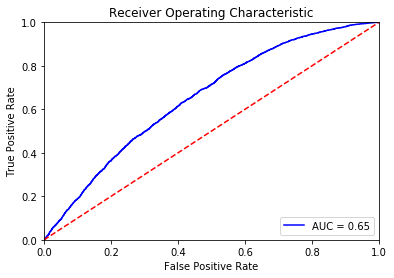

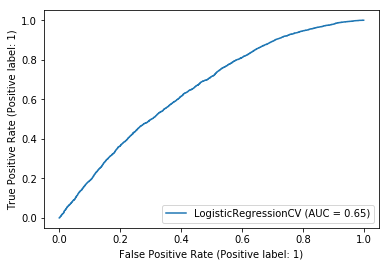

[1 0 0 ... 1 1 1]


In [35]:
import matplotlib.pyplot as plt  
from sklearn import datasets, metrics, model_selection, svm
from sklearn.metrics import roc_curve
# X, y = datasets.make_classification(random_state=0)
# X_train, X_test, y_train, y_test = model_selection.train_test_split(
#     X, y, random_state=0)
# clf = svm.SVC(random_state=0)
# clf.fit(X_train, y_train)




# ns_probs = [1 for _ in range(len(y_test))]
# # predict probabilities
# lr_probs = clf_2.predict_proba(X_test)
# # keep probabilities for the positive outcome only
# lr_probs = lr_probs[:, 1]
# # calculate scores
# ns_auc = roc_auc_score(testy, ns_probs)
# lr_auc = roc_auc_score(testy, lr_probs)
# # summarize scores
# print('No Skill: ROC AUC=%.3f' % (ns_auc))
# print('Logistic: ROC AUC=%.3f' % (lr_auc))
# # calculate roc curves
# ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
# lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# # plot the roc curve for the model
# pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# # axis labels
# pyplot.xlabel('False Positive Rate')
# pyplot.ylabel('True Positive Rate')
# # show the legend
# pyplot.legend()
# # show the plot
# pyplot.show()
# y_probas = clf_cv.predict_proba(X_test)
# skplt.metrics.plot_roc_curve(y_true, y_probas)


probs = clf_cv.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('foo.png')
plt.show()



metrics.plot_roc_curve(clf_cv, X_test, y_test)  
plt.show()             

print(clf_cv.predict(X_test))


# Logistic Regression Experiments



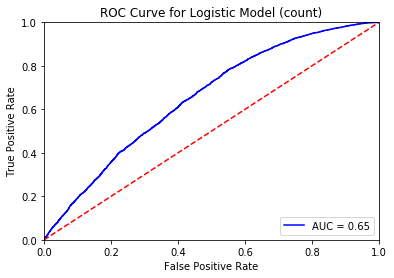

0.6109949468548528
----------------------------------


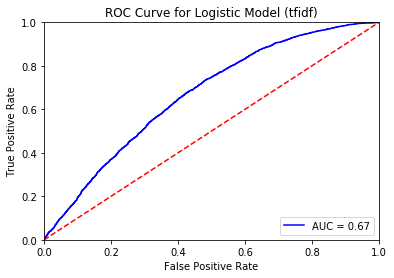

0.624063425683917
----------------------------------
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity w

cannot compute similarity with no input %s ['Nirmama']
cannot compute similarity with no input %s ['1960s', 'ANTHEMS']
cannot compute similarity with no input %s ['L.S.G', '...', '...', '...', '...', '...', '.T.I.G.H.T']
cannot compute similarity with no input %s []
cannot compute similarity with no input %s ['****1/2']
cannot compute similarity with no input %s ['5.0']
cannot compute similarity with no input %s ['Unbeliavable']
cannot compute similarity with no input %s ['Yee-ouch']
cannot compute similarity with no input %s []
cannot compute similarity with no input %s ['Pleeaaaaaaseeeeee']
cannot compute similarity with no input %s ['melvins', 'staq']
cannot compute similarity with no input %s ['Smoooooooooth']
cannot compute similarity with no input %s ['Grrrrrrrrrowl']
cannot compute similarity with no input %s ['SPEEDBALL', 'MEOTEORS']
cannot compute similarity with no input %s ['SUPER-CHARGED']
cannot compute similarity with no input %s ['Mindblowing']
cannot compute similarity 

cannot compute similarity with no input %s ['Mindblowing']
cannot compute similarity with no input %s ['...']
cannot compute similarity with no input %s ['O.K..']
cannot compute similarity with no input %s ['Over-loaded']
cannot compute similarity with no input %s ['Bumbulatin']
cannot compute similarity with no input %s ['Awwful']
cannot compute similarity with no input %s ['3:36']
cannot compute similarity with no input %s ['***THEunderstanding***']
cannot compute similarity with no input %s ['...']
cannot compute similarity with no input %s ['Woo-hoo']
cannot compute similarity with no input %s ['Tererible']
cannot compute similarity with no input %s ['Bizaar']
cannot compute similarity with no input %s ['Bizaar']
cannot compute similarity with no input %s ['3.75']
cannot compute similarity with no input %s ['OverHyped']
cannot compute similarity with no input %s ['SSSSSMokin']
cannot compute similarity with no input %s ['staind']
cannot compute similarity with no input %s ['Mildsto

cannot compute similarity with no input %s ['G-G-G-G-G-G-', 'G-UNIT']
cannot compute similarity with no input %s ['afroman']
cannot compute similarity with no input %s ['G-', 'Uniiiiiiit']
cannot compute similarity with no input %s ['I-have-no-mind']
cannot compute similarity with no input %s ['Excellet']
cannot compute similarity with no input %s ['G-Unit', 'style.Pleez', '...']
cannot compute similarity with no input %s ['Gangstafather']
cannot compute similarity with no input %s ['shyne']
cannot compute similarity with no input %s ['OVERATED']
cannot compute similarity with no input %s ['G.A.N.G.S.T.E.R']
cannot compute similarity with no input %s ['COOOOOOOL']
cannot compute similarity with no input %s ['ZZZZZZZZZZZ']
cannot compute similarity with no input %s ['FABULEUX']
cannot compute similarity with no input %s ['1/2']
cannot compute similarity with no input %s ['Whew..']
cannot compute similarity with no input %s ['...']
cannot compute similarity with no input %s ['Catchy..']


cannot compute similarity with no input %s []
cannot compute similarity with no input %s ['Eeeeeeeeeeeeeeeeexcellent']
cannot compute similarity with no input %s ["''kstr't", "''", "'stri", "'pjaer"]
cannot compute similarity with no input %s ['Miaww']
cannot compute similarity with no input %s ['So-So']
cannot compute similarity with no input %s ['of']
cannot compute similarity with no input %s ['Skyscraped']
cannot compute similarity with no input %s ['runum-runum-runum']
cannot compute similarity with no input %s []
cannot compute similarity with no input %s ['bore-fest']
cannot compute similarity with no input %s ['CTRL+A']
cannot compute similarity with no input %s ['Amaturish']
cannot compute similarity with no input %s ['of']
cannot compute similarity with no input %s ['lgcatalan']
cannot compute similarity with no input %s []
cannot compute similarity with no input %s ['Pitbull~']
cannot compute similarity with no input %s ['Descension']
cannot compute similarity with no input 

cannot compute similarity with no input %s ['Mr.Krabs']
cannot compute similarity with no input %s ['UNPLEASENT']
cannot compute similarity with no input %s ['FARKLE']
cannot compute similarity with no input %s ['geotracks']
cannot compute similarity with no input %s ['Awsomness']
cannot compute similarity with no input %s ['Cardstock']
cannot compute similarity with no input %s ['So.Damn.Cute']
cannot compute similarity with no input %s ['pupm']
cannot compute similarity with no input %s ['pleo']
cannot compute similarity with no input %s ['picturereka']
cannot compute similarity with no input %s ['Duploooooooowesome']
cannot compute similarity with no input %s ['decoArt']
cannot compute similarity with no input %s ['RftG']
cannot compute similarity with no input %s ['Perfect~']
cannot compute similarity with no input %s ['Bargus']
cannot compute similarity with no input %s ['B-O-R-I-N-G']
cannot compute similarity with no input %s ['...', '..G', '...', '...', '...', '.A', '...', '..S

cannot compute similarity with no input %s ['Finntastic']
cannot compute similarity with no input %s ['LALALALALALA']
cannot compute similarity with no input %s ['Over-Complication-Itis']
cannot compute similarity with no input %s ['DINo']
cannot compute similarity with no input %s ['Fun..']
cannot compute similarity with no input %s ['.baterias']
cannot compute similarity with no input %s ['60']
cannot compute similarity with no input %s ['So-so']
cannot compute similarity with no input %s ['Dragontastic']
cannot compute similarity with no input %s ['playdoh']
cannot compute similarity with no input %s ['uhhhhhh']
cannot compute similarity with no input %s ['DecepticonFan']
cannot compute similarity with no input %s ['Fan-tas-tic']
cannot compute similarity with no input %s ['Octonaut', 'Must-Have']
cannot compute similarity with no input %s ['Octopod']
cannot compute similarity with no input %s ['I-Spy']
cannot compute similarity with no input %s ['puzzleball']
cannot compute similar

cannot compute similarity with no input %s ['SQUIGZ']
cannot compute similarity with no input %s ['Arachnifabulous']
cannot compute similarity with no input %s ['sdcc', '2013', 'Webarella']
cannot compute similarity with no input %s ['Aquabot']
cannot compute similarity with no input %s ['Conterfeit']
cannot compute similarity with no input %s []
cannot compute similarity with no input %s ['AtmoSphere']
cannot compute similarity with no input %s ['O.K']
cannot compute similarity with no input %s ['Boooooooooo']
cannot compute similarity with no input %s ['Unreall']
cannot compute similarity with no input %s ['Clawd', 'Draculaura']
cannot compute similarity with no input %s ['Tape-tastic']
cannot compute similarity with no input %s ['Tapeffiti']
cannot compute similarity with no input %s ['So-so']
cannot compute similarity with no input %s ['Rainbow-tastic']
cannot compute similarity with no input %s ['viperine']
cannot compute similarity with no input %s ['Mr.Endy']
cannot compute simi

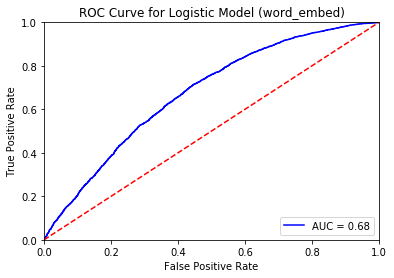

0.6330371144798745
----------------------------------


In [36]:

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.metrics import accuracy_score


for word_feature_type in ['count', 'tfidf', 'word_embed']:
    # generate features
    final_df = df_raw_data[['overall', 'helpful']]
    feature_df = generate_features(df_raw_data, word_feature_type, ['\.', '\$', '!', '#',',', '%', '='])

    final_df = pd.concat([final_df, feature_df], axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(final_df.drop(columns=['helpful']), 
                                                    final_df['helpful'], train_size=0.9)
    
    clf_cv = LogisticRegressionCV(cv=5).fit(X_train, y_train)
    
    
    probs = clf_cv.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('ROC Curve for Logistic Model ({})'.format(word_feature_type))
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig('lm_{}.png'.format(word_feature_type))
    plt.show()
    
    print(accuracy_score(y_test, clf_cv.predict(X_test)))
    print("----------------------------------")
    
    


In [14]:
import torch
from torch.nn import Linear, Dropout, Softmax
import torch.nn as nn

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm 
# from tqdm.notebook import tqdm


In [28]:
class FCN(nn.Module):
    
    def __init__(self, initial_size):
        super(FCN, self).__init__()
        
        self.initial_size = initial_size
        self.linear_1 = Linear(initial_size, 1024)
        self.linear_2 = Linear(1024, 2048)
        self.linear_3 = Linear(2048, 1024)
        self.linear_4 = Linear(1024, 256)
        self.linear_5 = Linear(256, 2)
        
    def forward(self, x):
        out = self.linear_1(x)
        out = F.relu(out)
        out = self.linear_2(out)
        out = F.relu(out)
        out = self.linear_3(out)
        out = F.relu(out)
        out = self.linear_4(out)
        out = F.relu(out)
        out = self.linear_5(out)
        
        out = F.softmax(out, dim=-1)
        
        return out
    
class FCNModel():
    def __init__(self, initial_size, model_filename, exp_dirname):
        self.fcn = FCN(initial_size)
        self.initial_size = initial_size
        self.optimizer = torch.optim.Adam(self.fcn.parameters())
        
        self.model_filename = model_filename
        self.exp_dirname = exp_dirname
        self.writer = SummaryWriter(self.exp_dirname)

        
        
    def train(self, num_epochs, X_train, y_train, X_val, y_val):
        
        train_dataset = TensorDataset(torch.from_numpy(X_train.values).float(),
                                      torch.from_numpy(y_train.values).long())
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        
        best_val_accuracy = float('-inf')
        
        for epoch in range(1, num_epochs + 1):
            running_loss = 0
            batch_counter = 0
            for batch in train_loader:
                
                X_batch, y_batch = batch
                
                self.optimizer.zero_grad()
                
                cur_logits = self.fcn(X_batch)
                
                loss = F.cross_entropy(cur_logits, y_batch)
                running_loss += loss.item()
                
                if batch_counter % 100 == 99:    # every 100 mini-batches...

                    # ...log the running loss
                    self.writer.add_scalar('training loss',
                                    running_loss / 100,
                                    epoch * len(train_loader) + batch_counter)
                    print("Running Loss for Step {}: {}".format(epoch * len(train_loader) + batch_counter,
                                                               running_loss / 100))
                    
                    running_loss = 0.0
                
                batch_counter += 1
                

                loss.backward()
                self.optimizer.step()
                
        cur_val_accuracy = self.evaluate(X_val, y_val, use_best=False)
        print("Validation Accuracy for Epoch: {} is {}".format(epoch, cur_val_accuracy))
        if cur_val_accuracy > best_val_accuracy:
            best_val_accuracy = cur_val_accuracy
            torch.save(self.fcn.state_dict(), self.model_filename)
        
        
        
    def evaluate(self, X, y, use_best=False):
        eval_model = None
        if use_best:
            eval_model = FCN(self.initial_size)
            eval_model.load_state_dict(torch.load(self.model_filename))
        else:
            eval_model = self.fcn
        
        eval_dataset = TensorDataset(torch.from_numpy(X.values).float(),
                                      torch.from_numpy(y.values).long())
        eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=True)
        
        total_correct = 0
        with torch.no_grad():
            eval_model.eval()
            
            for X_batch, y_batch in eval_loader:

                logits = eval_model(X_batch)
                _, class_predictions = torch.max(logits, dim=-1)
                total_correct += (class_predictions == y_batch).float().sum()

            
        eval_model.train()
        return total_correct / len(X)
            
        
    def predict_proba(self, X):
        eval_model = FCN(self.initial_size)
        eval_model.load_state_dict(torch.load(self.model_filename))
        eval_model.eval()
        
        proba = eval_model(torch.from_numpy(X.values).float())
        
        return proba
        
        
model = FCNModel(X_train.shape[1], 'foo_nn.pt', 'runs/foo_exp')
model.train(10, X_train, y_train, X_test, y_test)


# train = TensorDataset(torch.from_numpy(X_train.values).float(),
#                       torch.from_numpy(y_train.values).float())
# train_loader = DataLoader(train, batch_size=32, shuffle=True)
# model = FCN(X_train.shape[1])

Running Loss for Step 3327: 0.6916833066940308
Running Loss for Step 3427: 0.6875881165266037
Running Loss for Step 3527: 0.6834778565168381
Running Loss for Step 3627: 0.6840969747304917
Running Loss for Step 3727: 0.6769210261106491
Running Loss for Step 3827: 0.6804118478298187
Running Loss for Step 3927: 0.6737269359827042
Running Loss for Step 4027: 0.6668057036399841
Running Loss for Step 4127: 0.6671830755472183
Running Loss for Step 4227: 0.670536025762558
Running Loss for Step 4327: 0.6664166045188904
Running Loss for Step 4427: 0.6635142797231675
Running Loss for Step 4527: 0.6664041328430176
Running Loss for Step 4627: 0.6613648653030395
Running Loss for Step 4727: 0.6578787076473236
Running Loss for Step 4827: 0.6668510884046555
Running Loss for Step 4927: 0.6664636510610581
Running Loss for Step 5027: 0.6685475552082062
Running Loss for Step 5127: 0.6620971488952637
Running Loss for Step 5227: 0.6567501282691955
Running Loss for Step 5327: 0.6569692713022232
Running Loss f

Running Loss for Step 20767: 0.5715245330333709
Running Loss for Step 20867: 0.5663471573591232
Running Loss for Step 20967: 0.5776244157552719
Running Loss for Step 21067: 0.5728321731090545
Running Loss for Step 21167: 0.5765161561965942
Running Loss for Step 21267: 0.5757130289077759
Running Loss for Step 21367: 0.565661161839962
Running Loss for Step 21467: 0.5802411833405494
Running Loss for Step 21567: 0.5862057980895042
Running Loss for Step 21667: 0.568636282980442
Running Loss for Step 21767: 0.5668323278427124
Running Loss for Step 21867: 0.5699942946434021
Running Loss for Step 21967: 0.577020732164383
Running Loss for Step 22067: 0.5730730512738228
Running Loss for Step 22167: 0.5775577583909035
Running Loss for Step 22267: 0.561342551112175
Running Loss for Step 22367: 0.5618691796064377
Running Loss for Step 22467: 0.5818742787837983
Running Loss for Step 22567: 0.5686209392547608
Running Loss for Step 22695: 0.529559206366539
Running Loss for Step 22795: 0.53211743175983

In [76]:
for X_batch, y_batch in train_loader:
    
    print(X_batch.size(), model(X_batch).size())
    break

<class 'torch.Tensor'>
torch.Size([32, 615]) torch.Size([32, 2])


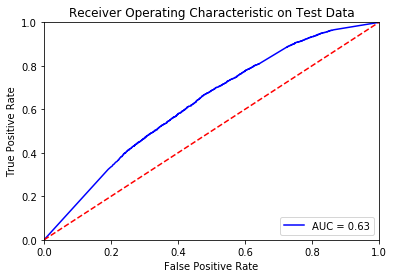

In [33]:

probs = model.predict_proba(X_test).detach().numpy()
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic on Test Data')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('nn_test_data.png')
plt.show()

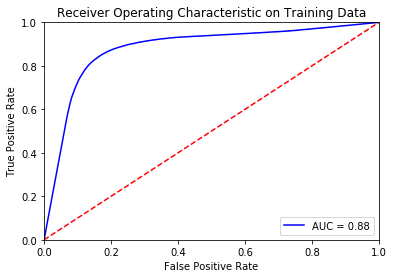

In [34]:
probs = model.predict_proba(X_train).detach().numpy()
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_train, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic on Training Data')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('nn_train_data.png')
plt.show()

## NN Experiments

Validation Accuracy for Epoch: 5 is 0.6120066046714783


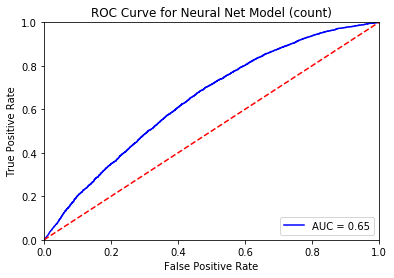

0.6151768600801534
----------------------------------


Validation Accuracy for Epoch: 5 is 0.6049490571022034


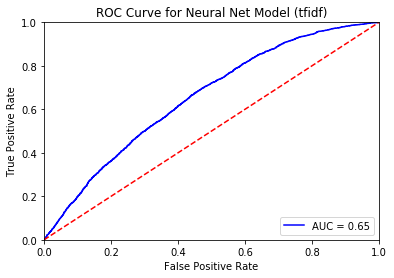

0.6176163094615786
----------------------------------
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity with no input %s []
cannot compute similarity 

cannot compute similarity with no input %s ['DISCARDABLE']
cannot compute similarity with no input %s ['777-9311']
cannot compute similarity with no input %s ['must-have']
cannot compute similarity with no input %s ['1984']
cannot compute similarity with no input %s ['1984']
cannot compute similarity with no input %s ['SQUAAAWK']
cannot compute similarity with no input %s ['Snoozville']
cannot compute similarity with no input %s ['One-HIT', 'WOnders']
cannot compute similarity with no input %s ['YEY-YAH']
cannot compute similarity with no input %s ['Lovesexy']
cannot compute similarity with no input %s ['Lovesexy']
cannot compute similarity with no input %s ['LUKEWARM']
cannot compute similarity with no input %s ['Bloody-Superb-Stunning-Masterpiece']
cannot compute similarity with no input %s ['Funkylicious']
cannot compute similarity with no input %s ['BloodSugarSexBrilliant']
cannot compute similarity with no input %s ['ZzzzzssGreat']
cannot compute similarity with no input %s ['Unec

cannot compute similarity with no input %s ['Tango-Trance', 'Trance-Tango']
cannot compute similarity with no input %s []
cannot compute similarity with no input %s ['...', '...', '.wow']
cannot compute similarity with no input %s ['Nameanuheard']
cannot compute similarity with no input %s ['Damnnnnnn']
cannot compute similarity with no input %s ['Dissapointing', 'Wu-Album']
cannot compute similarity with no input %s ['Snoozefest', '2003']
cannot compute similarity with no input %s ['Snora']
cannot compute similarity with no input %s ['*No', 'Words*']
cannot compute similarity with no input %s []
cannot compute similarity with no input %s ['Ughhh', '...']
cannot compute similarity with no input %s []
cannot compute similarity with no input %s ['4.8']
cannot compute similarity with no input %s ['Sha-Doo']
cannot compute similarity with no input %s ['nostalgia-laden']
cannot compute similarity with no input %s ['LISTENABLE']
cannot compute similarity with no input %s ['OKIMGONNATRYANDBER

cannot compute similarity with no input %s ['Hmm..']
cannot compute similarity with no input %s ['Globalaza']
cannot compute similarity with no input %s []
cannot compute similarity with no input %s ['A-hem', '...']
cannot compute similarity with no input %s ['Dumbasses']
cannot compute similarity with no input %s ['...']
cannot compute similarity with no input %s ['DISSERVICE']
cannot compute similarity with no input %s ['Dissapointment']
cannot compute similarity with no input %s ['Calicrustication']
cannot compute similarity with no input %s ['...']
cannot compute similarity with no input %s ['KILLA']
cannot compute similarity with no input %s ['BluesLady']
cannot compute similarity with no input %s ['--']
cannot compute similarity with no input %s ['Retro-grungers']
cannot compute similarity with no input %s ['...']
cannot compute similarity with no input %s ['...']
cannot compute similarity with no input %s ['Enterludes']
cannot compute similarity with no input %s ['CHINGY', 'HOOD

cannot compute similarity with no input %s ['Fun-o-licious']
cannot compute similarity with no input %s ['Fanstastic', '...']
cannot compute similarity with no input %s ['BOOOOOORING']
cannot compute similarity with no input %s ['24', "''", 'Playmats']
cannot compute similarity with no input %s ['Durable/Fun']
cannot compute similarity with no input %s ['Ele-', 'Funnnnnn']
cannot compute similarity with no input %s ['eleflop']
cannot compute similarity with no input %s ['A++++']
cannot compute similarity with no input %s ['Peek-A-Boring']
cannot compute similarity with no input %s ['MOOOOOO']
cannot compute similarity with no input %s ['ON/OFF']
cannot compute similarity with no input %s ['Spongebob+Leapster=Learning']
cannot compute similarity with no input %s ['wowwwwwww']
cannot compute similarity with no input %s ['Ele-fun']
cannot compute similarity with no input %s ['Magz-X']
cannot compute similarity with no input %s ['Whoo-whooooo']
cannot compute similarity with no input %s ['

cannot compute similarity with no input %s ['weebles']
cannot compute similarity with no input %s ['FuzzBOOdooles']
cannot compute similarity with no input %s ['mwahahahahahahaha']
cannot compute similarity with no input %s ['cyber-megatron']
cannot compute similarity with no input %s ['ravage24/7']
cannot compute similarity with no input %s ['BLURRRRRRRRRRRRRRRR', '...']
cannot compute similarity with no input %s ['Brwester']
cannot compute similarity with no input %s ['Frostini']
cannot compute similarity with no input %s ['Over-Complication-itis']
cannot compute similarity with no input %s ['Masterpeice']
cannot compute similarity with no input %s ['play-doh']
cannot compute similarity with no input %s ['mr.', 'lightyear']
cannot compute similarity with no input %s ['Izoso']
cannot compute similarity with no input %s ['Obsesssed']
cannot compute similarity with no input %s ['Az-Mazing']
cannot compute similarity with no input %s ['WHheeeeeeeeeeeeeeeeeeeeeee']
cannot compute similari

cannot compute similarity with no input %s ['willisf158']
cannot compute similarity with no input %s []
cannot compute similarity with no input %s ['Fun-ho']
cannot compute similarity with no input %s ['predaking']
cannot compute similarity with no input %s ['sherie']
cannot compute similarity with no input %s ['Fearleading', 'Werecats']
cannot compute similarity with no input %s ['cheapp']
cannot compute similarity with no input %s ['Dissapointing']
cannot compute similarity with no input %s ['FFFRRREEEIIIZZAAAAA']
cannot compute similarity with no input %s ['FRIIIIEEEEEZAAAAAA']
cannot compute similarity with no input %s ['``', 'Caaaaaar', "''"]
cannot compute similarity with no input %s ['Umirrific']
cannot compute similarity with no input %s ['thinck']
cannot compute similarity with no input %s ['Spa-la-la']
cannot compute similarity with no input %s ['yessss']
cannot compute similarity with no input %s ['GORE-geous']
cannot compute similarity with no input %s ['Monsterlicuous']
ca

Validation Accuracy for Epoch: 5 is 0.6168859601020813


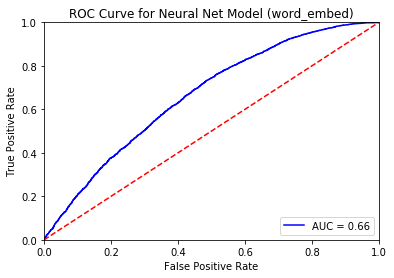

0.6238891792995296
----------------------------------


In [39]:
from sklearn.metrics import accuracy_score


for word_feature_type in ['count', 'tfidf', 'word_embed']:
    # generate features
    final_df = df_raw_data[['overall', 'helpful']]
    feature_df = generate_features(df_raw_data, word_feature_type, ['\.', '\$', '!', '#',',', '%', '='])

    final_df = pd.concat([final_df, feature_df], axis=1)
    
    
    train_ratio = 0.80
    validation_ratio = 0.10
    test_ratio = 0.10

    X_train, X_test, y_train, y_test = train_test_split(final_df.drop(columns=['helpful']), 
                                                        final_df['helpful'], 
                                                        test_size=1 - train_ratio)

    X_val, X_test, y_val, y_test = train_test_split(X_test, 
                                                    y_test, 
                                                    test_size=test_ratio/(test_ratio + validation_ratio))
    
    
    clf_cv = LogisticRegressionCV(cv=5).fit(X_train, y_train)
    
    model = FCNModel(X_train.shape[1], 'nn_model_{}'.format(word_feature_type))
    model.train(5, X_train, y_train, X_val, y_val)
    
    
    
    probs = model.predict_proba(X_test).detach().numpy()
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('ROC Curve for Neural Net Model ({})'.format(word_feature_type))
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig('nn_{}.png'.format(word_feature_type))
    plt.show()
    
    print(accuracy_score(y_test, clf_cv.predict(X_test)))
    print("----------------------------------")